In [67]:
from corner import corner
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from calibration.least_squares import least_squares, ChainStats

In [60]:
RANDOM_SUBSAMPLE = None

In [61]:
%%time
df = pd.read_csv('ps1_des-grizy.csv.bz2', engine='pyarrow')

if RANDOM_SUBSAMPLE is not None:
    df = df.sample(n=RANDOM_SUBSAMPLE, replace=False, random_state=0)

x = np.stack([df["des_mag_g"], df["des_mag_r"], df["des_mag_i"], df["ps1_mag_r"]], axis=1)
sigma2 = np.stack([df["des_magerr_g"], df["des_magerr_r"], df["des_magerr_i"], df["ps1_magerr_r"]], axis=1)**2

del df


r_ps1_des = x[:, 3] - x[:, 1]
gr_des = x[:, 0] - x[:, 1]
ri_des = x[:, 1] - x[:, 2]

print(f'{x.shape[0]} data points')

640646 data points
CPU times: user 6.55 s, sys: 281 ms, total: 6.83 s
Wall time: 6.01 s


In [62]:
%%time

states, ln_probs = least_squares(
    type='ordinal',
    x=x,
    sigma2=sigma2,
    initial_slopes=[0.020, 1.119, -0.139, -1.0],
    initial_intercept=0.014,
    initial_dispersion=0.015,
    with_dispersion=True,
    # ps1_r = des_r + alpha (des_r - des_i) + beta (des_g - des_r) + intercept + dispersion * N(0, 1)
    # 3       1              1       2              0       1        4           5
    # slope0 = beta = internal[1]
    # slope1 = 1 + alpha - beta = 1 + internal[0] - internal[1]
    # slope2 = -alpha = -internal[0]
    # slope3 = -1
    ls_params_to_internal=lambda ls_param: jax.numpy.r_[-ls_param[2], ls_param[0], ls_param[4], ls_param[5]],
    internal_params_to_ls=lambda internal: jax.numpy.r_[internal[1], 1 + internal[0] - internal[1], -internal[0], internal[2], internal[3]],
    # residual_fn=lambda x: jax.numpy.arctan(x),
    # ask dispersion to be not so large
    # ln_prior=lambda internal: HalfNormal(scale=0.001).log_prob(internal[-1]),
    num_samples=10_000,
    num_burnin=100,
    nuts_kwargs=dict(step_size=1e-5, parallel_iterations=1),
)

CPU times: user 17min 36s, sys: 48.2 s, total: 18min 25s
Wall time: 13min 58s


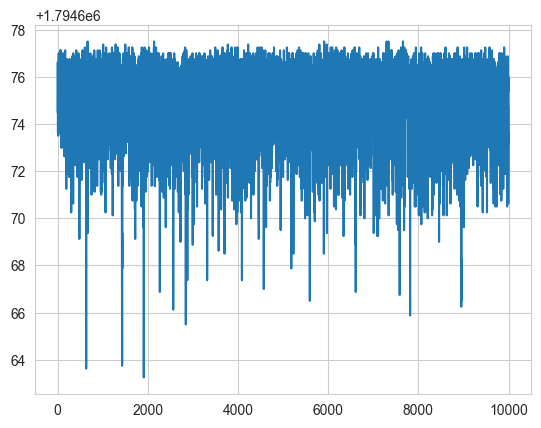

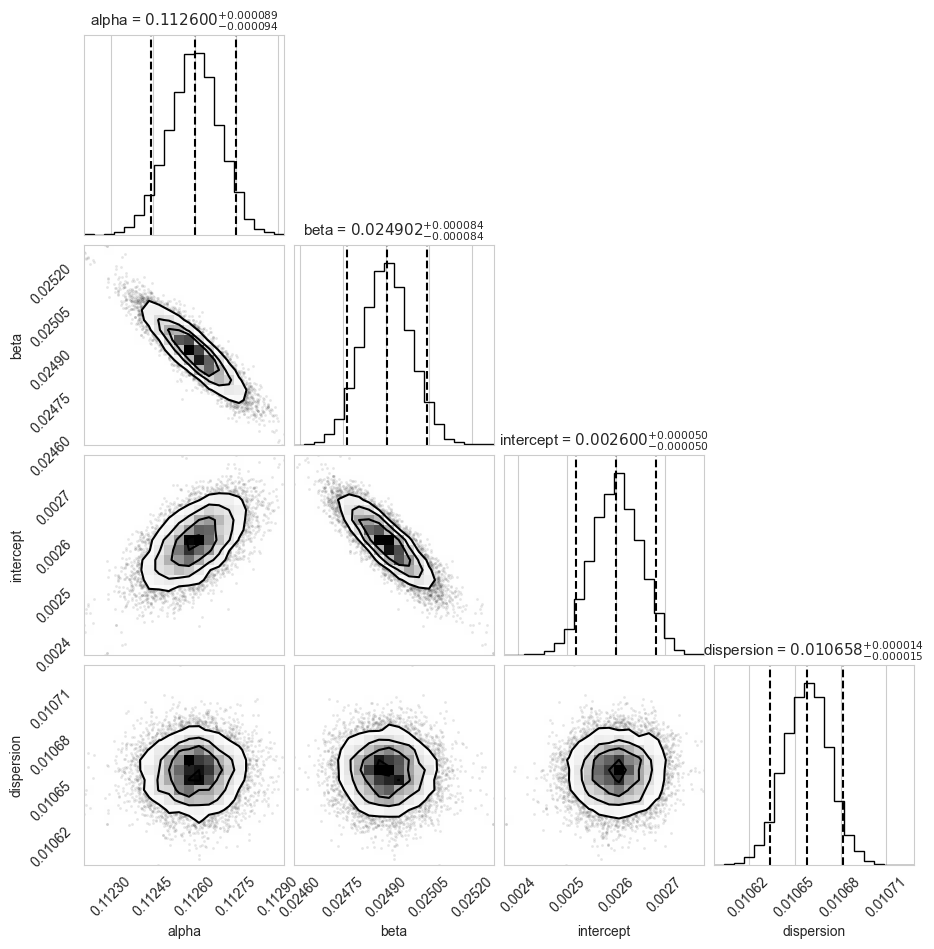

In [63]:
plt.figure()
plt.plot(ln_probs)

corner(
    data=np.asarray(states),
    labels=['alpha', 'beta', 'intercept', 'dispersion'],
    quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    title_fmt='.6f',
    title_kwargs={"fontsize": 11},
)

stats = ChainStats.from_states(states)

Text(0.5, 0, 'PS1 r (data - model)')

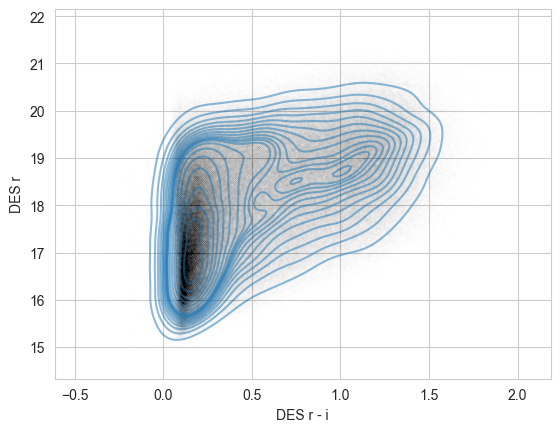

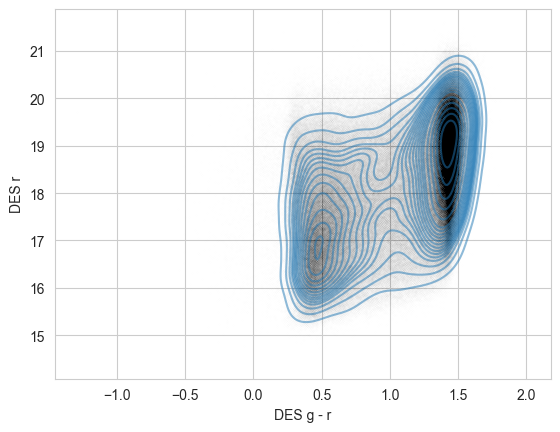

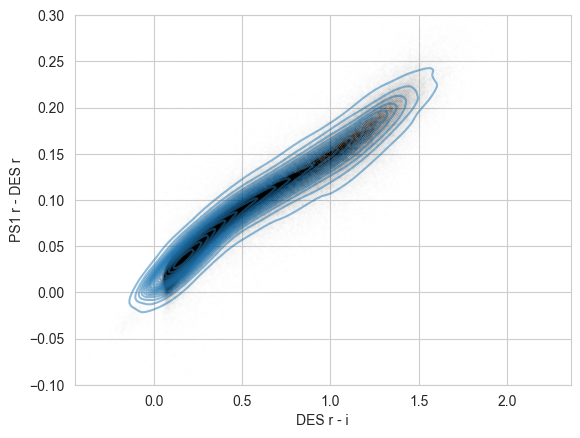

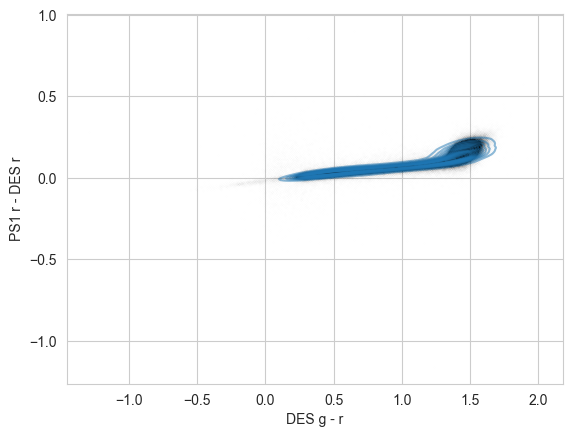

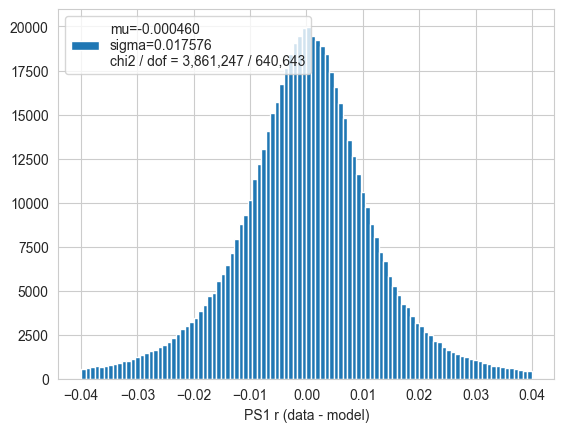

In [101]:
alpha, beta, intercept, dispersion = stats.median

plt.figure()
n_kde = 10_000
idx = np.random.choice(len(ri_des), min(n_kde, len(ri_des)), replace=False)
sns.kdeplot(x=ri_des[idx], y=x[idx, 1], levels=20, alpha=0.5)
plt.scatter(ri_des, x[:, 1], color='k', s=0.05, alpha=0.01)
plt.xlabel('DES r - i')
plt.ylabel('DES r')

plt.figure()
n_kde = 10_000
idx = np.random.choice(len(gr_des), min(n_kde, len(gr_des)), replace=False)
sns.kdeplot(x=gr_des[idx], y=x[idx, 1], levels=20, alpha=0.5)
plt.scatter(gr_des, x[:, 1], color='k', s=0.05, alpha=0.01)
plt.xlabel('DES g - r')
plt.ylabel('DES r')

plt.figure()
n_kde = 10_000
idx = np.random.choice(len(ri_des), min(n_kde, len(ri_des)), replace=False)
sns.kdeplot(x=ri_des[idx], y=r_ps1_des[idx], levels=20, alpha=0.5)
plt.scatter(ri_des, r_ps1_des, color='k', s=0.05, alpha=0.01)
plt.ylim(-0.1, 0.3)
plt.xlabel('DES r - i')
plt.ylabel('PS1 r - DES r')

plt.figure()
n_kde = 10_000
idx = np.random.choice(len(gr_des), min(n_kde, len(ri_des)), replace=False)
sns.kdeplot(x=gr_des[idx], y=r_ps1_des[idx], levels=20, alpha=0.5)
plt.scatter(gr_des, r_ps1_des, color='k', s=0.05, alpha=0.01)
# plt.ylim(-0.1, 0.3)
plt.xlabel('DES g - r')
plt.ylabel('PS1 r - DES r')

plt.figure()
residuals = r_ps1_des - (alpha * ri_des + beta * gr_des + intercept)
residuals_range = np.linspace(-0.04, 0.04, 100)
residuals_mu, residuals_sigma = np.mean(residuals), np.std(residuals, ddof=3)
residuals_chi2 = np.sum(residuals**2 / (sigma2 @ np.square([beta, 1 + alpha + beta, -alpha, -1] + dispersion**2)))
plt.hist(residuals, bins=residuals_range.shape[0], range=[residuals_range[0], residuals_range[-1]],
         label=f'mu={residuals_mu:.6f}\nsigma={residuals_sigma:.6f}\nchi2 / dof = {int(residuals_chi2):,d} / {len(residuals) - 3:,d}')
plt.legend()
plt.xlabel('PS1 r (data - model)')

In [64]:
# alpha, intercept, dispersion = stats.median
#
# plt.figure()
# n_kde = 10_000
# idx = np.random.choice(len(ri_des), min(n_kde, len(ri_des)), replace=False)
# sns.kdeplot(x=ri_des[idx], y=x[idx,0], levels=20, alpha=0.5)
# plt.scatter(ri_des, x[:, 0], color='k', s=0.05, alpha=0.01)
# plt.xlabel('DES r - i')
# plt.ylabel('DES r')
#
# plt.figure()
# n_kde = 10_000
# idx = np.random.choice(len(ri_des), min(n_kde, len(ri_des)), replace=False)
# sns.kdeplot(x=ri_des[idx], y=r_ps1_des[idx], levels=20, alpha=0.5)
# plt.scatter(ri_des, r_ps1_des, color='k', s=0.05, alpha=0.01)
# # plt.xlim(-0.5, 2)
# plt.ylim(-0.1, 0.3)
# plt.xlabel('DES r - i')
# plt.ylabel('PS1 r - DES r')
#
# plt.figure()
# plt.hist(r_ps1_des - (alpha * ri_des + intercept), bins=100, range=(-0.04, 0.04))
# plt.xlabel('PS1 r (data - model)')

ValueError: too many values to unpack (expected 3)